In [1]:
from typing_extensions import Annotated
from typing_extensions import TypedDict

from langgraph.graph import START
from langgraph.graph import END
from langgraph.graph import StateGraph
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages

from langchain_core.messages import AIMessage
from langchain_core.messages import AnyMessage
from langchain_core.messages import HumanMessage


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    extra_field: int


def node(state: State):
    new_message = AIMessage("Hello!")
    new_extra_field = state.get("extra_field", 0) + 1
    return {"messages": [new_message], "extra_field": new_extra_field}
    # return new_message
    # Jika return seperti ini (tanpa dictionary dengan salah satu key di State)
    # Maka hasilnya dianggap tidak valid, dan tidak akan dihiraukan


graph_builder = StateGraph(State)
graph_builder.add_node(node)
graph_builder.add_edge(START, "node")
graph_builder.add_edge("node", END)
graph = graph_builder.compile()

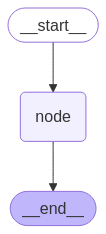

In [2]:
from IPython.display import Image, display

# Visualize your graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
result = graph.invoke({"messages": [HumanMessage("Hi")]})
display(result)

for message in result["messages"]:
    message.pretty_print()

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='51dd26c0-c669-4bc1-b37a-6959c65a1416'),
  AIMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='2313bcef-928a-416d-8697-34ffcb26a1cc')],
 'extra_field': 1}

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


In [4]:
# Source: https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-3-adding-memory-to-the-chatbot
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph_builder = StateGraph(State)
graph_builder.add_node(node)
graph_builder.add_edge(START, "node")
graph_builder.add_edge("node", END)
graph = graph_builder.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "1"}}

result = graph.invoke({"messages": [HumanMessage("Hi")]}, config=config)
display(result)

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='e3cb2b13-f513-4ceb-b576-88025bf00db4'),
  AIMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='23f10af2-b33c-4c46-a2dc-2f269d3b37de')],
 'extra_field': 1}

In [5]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


In [6]:
# Print "ALL" state from memory with thread_id=1
# Source: https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-3-adding-memory-to-the-chatbot
from pprint import pprint

result = graph.invoke({"messages": [HumanMessage("Hi")]}, config=config)  # 2nd invoke
result = graph.invoke({"messages": [HumanMessage("Hi")]}, config=config)  # 3rd invoke

pprint(graph.get_state(config)[0])

{'extra_field': 3,
 'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='e3cb2b13-f513-4ceb-b576-88025bf00db4'),
              AIMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='23f10af2-b33c-4c46-a2dc-2f269d3b37de'),
              HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='c88de420-ee88-44f0-ac96-23fe7f5923f2'),
              AIMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='1bebd222-e670-442c-b84c-3aae094bec46'),
              HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='240528c1-1b80-45c6-8446-8b0902a3f666'),
              AIMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='cf55e417-9dfb-4b2b-9033-6e0959bac9e4')]}
